In [1]:
import nltk
import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import networkx as nx

from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
stop_words = stopwords.words('english')

### Read in the Survey Responses

In [2]:
responses = pd.read_csv('data/Behavioral Health Survey.csv', parse_dates=['Timestamp'])

### View First Five Rows

In [3]:
responses.head()

,Timestamp,Please place a check to the left of the interventions listed below that you are involved with at PACE:,"From your perspective/discipline, what is the purpose of Behavioral Health programs and services at PACE, including participants served in hybrid model?","In your experience, which Behavioral Health interventions are most beneficial to PACE participants?",Describe the reasons you think these are beneficial.,What other Behavioral Health interventions and/or services are needed that PACE does not currently provide?,What participant problems or needs are not currently addressed by Behavioral Health actions/programming?,"Do you find the documentation of Behavioral Health services at PACE adequate? If not, how could it be improved?",What training or education related to Behavioral Health programs and services do you need?
0,2018-10-03 14:38:00,b. Behavioral Health education and training,To provide our participants with the best care...,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-10-03 14:49:00,"b. Behavioral Health education and training, d...",Behavioral health plays a significant role in ...,Psychiatry and counseling; music and meditation,ability to prescribe medications; means of esc...,family counseling,addiction,yes,"""failure to thrive"" caregiver support"
2,2018-10-03 14:50:00,"b. Behavioral Health education and training, c...",To ensure that we may either provide or refer ...,"Referrals, counselling, screening and support ...",We may be their first access into the mental h...,Community health referrals in Westerly area an...,Drug & alcohol & addiction services and many P...,unsure,The Process of how to make a referral etc
3,2018-10-03 14:58:00,Oversight of many of these,Provide for stabilization and treatment of beh...,"Music and Memory, Life-Enrichment, etc, Reiki,...",The first two + groups: Address the needs of ...,"Urgent/emergent access to care, substance abus...","Active substance/ETOH abuse, chronic mental il...",I think it is well documented!,Continual reinforcement. I think the original...
4,2018-10-03 16:05:00,r. None,Behavioral health is one area in the continuum...,"Counseling services, Caregiver support, Behavi...",Counseling services meets clients needs on a r...,Services and interventions for those who strug...,See answer above.,Documentation of services seems adequate to me...,I think it would be useful to have the tools t...


#### Parsing Question One

The answers for question one, which is column 2 of the dataset, are multiple choice. This results in each response starting with a single letter, followed by a period. 

These encompass the letters a to r, not including q. The list comprehension below uses an f-string to put the single lower case letter with a period in the list as long as that letter is within the first 19 of the alphabet and does not equal q.

In [4]:
answers = [f"{letter}." for letter in string.ascii_lowercase[:18] if letter!='q']

Next, we split the responses so that we have a list of the "words" that appear in the responses. We only want the letter of the response, so we next use list comprehension to make sure our list only contrains "words" found in our answer list. That is the list of a through r with a period after each character.

In [5]:
answer_one = []

for s in responses[responses.columns[1]].str.split():
    answer_one.append(s)

answer_one = [y for x in answer_one for y in x if y in answers]

Finally we can use value counts to see which answers appear most often and use that information to build a horizontal bar chart. 

In [6]:
value_counts = {}
for answer in answers:
    value_counts[answer] = len([ans for ans in answer_one if ans==answer])

In [7]:
plot_df = pd.DataFrame.from_dict(value_counts,
                                 orient='index',
                                 columns=['count']).reset_index().rename(columns={'index':'answer'})

In [8]:
plot_df['count'] = (plot_df['count'] / responses[responses.columns[1]].shape[0]) * 100

In [9]:
plot_df.sort_values(by='count', inplace=True)

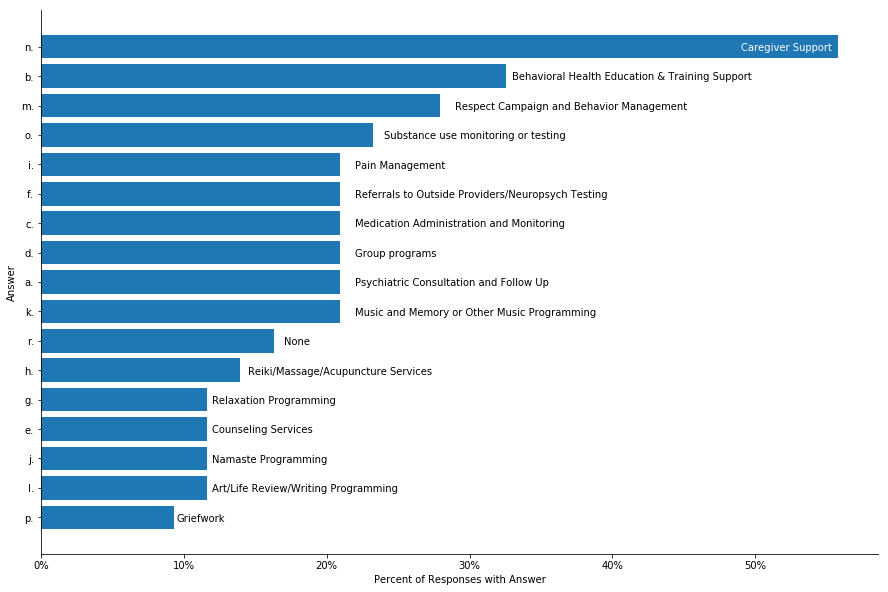

In [10]:
fig, ax = plt.subplots(figsize=(15,10))
plt.barh(plot_df['answer'], plot_df['count'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
#ax.set_title(('Please place a check to the left of the interventions listed below that you are involved with at PACE').title())
ax.set_xlabel('Percent of Responses with Answer')
ax.set_ylabel('Answer')
ax.text(49, 15.87, "Caregiver Support", color='white')
ax.text(33, 14.87, "Behavioral Health Education & Training Support")
ax.text(29, 13.87, "Respect Campaign and Behavior Management")
ax.text(24, 12.87, "Substance use monitoring or testing")
ax.text(22, 11.87, "Pain Management")
ax.text(22, 10.87, "Referrals to Outside Providers/Neuropsych Testing")
ax.text(22, 9.87, "Medication Administration and Monitoring")
ax.text(22, 8.87, "Group programs")
ax.text(22, 7.87, "Psychiatric Consultation and Follow Up")
ax.text(22, 6.87, "Music and Memory or Other Music Programming")
ax.text(17, 5.87, "None")
ax.text(14.5, 4.87, "Reiki/Massage/Acupuncture Services")
ax.text(12, 3.87, "Relaxation Programming")
ax.text(12, 2.87, "Counseling Services")
ax.text(12, 1.87, "Namaste Programming")
ax.text(12, 0.87, "Art/Life Review/Writing Programming")
ax.text(9.5, -0.13, "Griefwork");

To look at the next set of responses, which are all free text, we will use the textrank algorithm to find the 5 sentences that are most similar to all of the other responses to the question.

We begin by breaking each answer into a list sentences and then collecting those list in a dictionary, where each key is a question and each value is a list of each sentence in the responses to that question.

In [11]:
question_responses = {}

for col in responses.columns[1:]:
    answers = []
    for ans in responses[col].dropna():
        answers.append(sent_tokenize(ans))

    question_responses[col] = [y for x in answers for y in x]

Now we can split these sentences into words and use GloVe (more info here: https://nlp.stanford.edu/projects/glove/) to obtain vector representations of these words.

In [12]:
word_embeddings = {}
f = open('data/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

In [13]:
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in ''])
    return sen_new

We will also remove all punctuation, make all words lowercase and remove any stop words.

In [14]:
for q in question_responses.keys():
    question_responses[q] = pd.Series(question_responses[q]).str.replace("[^a-zA-Z]", " ")
    question_responses[q] = [s.lower() for s in question_responses[q]]
    question_responses[q] = [remove_stopwords(r.split()) for r in question_responses[q]]

Now that we have vectors for all the words in the responses, we can to build vector of the sentences. After that we will put together a similatriy matrix for each question.

In [44]:
response_vectors = {}

for q in question_responses.keys():
    answer_vectors = []
    for i in question_responses[q]:
        print(question_responses[q])
        if len(i) != 0:
            v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
            print(v)
        else:
            v = np.zeros((100,))
        answer_vectors.append(v)
    response_vectors[q] = answer_vectors

['b behavioral health education and training', 'b behavioral health education and training d group programs j namaste programming k music and memory or other music programming l art life review writing programming m respect campaign and behavior management', 'b behavioral health education and training c medication administration and monitoring f referrals to outside providers neuropsych testing g relaxation programming i', 'pain management j namaste programming k music and memory or other music programming m respect campaign and behavior management n caregiver support o', 'substance use monitoring or testing', 'oversight of many of these', 'r none', 'a', 'psychiatric consultation and follow up b behavioral health education and training d group programs e counseling services l art life review writing programming m respect campaign and behavior management n caregiver support o', 'substance use monitoring or testing p griefwork', 'b behavioral health education and training d group program

[-2.14617399e-02  2.54973893e-01  2.36870824e-01 -1.06280564e-01
 -7.54862160e-02  2.14909778e-01 -3.59165009e-01  9.10330250e-02
 -6.44860835e-02 -2.74259274e-02  8.25806864e-02  1.90900017e-02
  1.67764682e-01  1.51046861e-01  3.23925946e-02 -3.40539920e-01
  1.85756013e-01  1.66866862e-01 -4.48542586e-01  2.35285677e-01
  2.20212238e-01 -1.73896286e-01  2.21645164e-01  1.49721691e-01
  5.55118299e-02 -5.48901774e-03 -7.07885321e-02 -3.59062913e-01
  2.36662848e-01 -9.68555256e-02 -4.88012483e-02  5.02033451e-01
 -1.14181995e-01 -1.08270563e-02 -1.75441717e-02  4.07970735e-01
  1.51400878e-01 -2.02782765e-02 -7.17679175e-02 -2.93871238e-02
 -3.87389097e-01 -3.28525835e-01 -9.88732894e-02 -4.29419674e-01
 -2.35957861e-01 -7.43278023e-02  4.76223898e-03 -4.98491062e-02
 -9.11384777e-02 -8.16217023e-01 -7.62683364e-02  1.45589222e-01
  9.70358965e-02  1.09488357e+00 -1.04061615e-01 -2.00352988e+00
  7.27888195e-02 -2.65182289e-01  1.62764348e+00  3.25510184e-01
 -2.08575213e-01  5.91852

The similarity matrix is a square matrix, where $n$ is the number of sentences and each cell contains the cosine similarity score between two sentences.

In [16]:
similarity_matrices = {}

for q in question_responses.keys():
    sim_mat = np.zeros([len(question_responses[q]), len(question_responses[q])])
    for i in range(len(question_responses[q])):
        for j in range(len(question_responses[q])):
            if i != j:
                sim_mat[i][j] = cosine_similarity(response_vectors[q][i].reshape(1,100),
                                                  response_vectors[q][j].reshape(1,100))[0,0]
    similarity_matrices[q] = sim_mat

Finally, we can use `networkx` to turn our matrices into graphs where each node is an answer and their edges are similarity scores.

Using textrank algorithm, similar to pagerank, we rank the relevance of each sentence in the response, but instead of the probability of naviagating to a certain page, sentences are ranked on their similarity to all other sentences. This means they should be the most representative.

In [17]:
question_scores = {}
for q in similarity_matrices:
    nx_graph = nx.from_numpy_array(similarity_matrices[q])
    scores = nx.pagerank(nx_graph)
    question_scores[q] = scores

In [45]:
question_scores

{'Please place a check to the left of the interventions listed below that  you are involved with at PACE:': {0: 0.014281165866023342,
  1: 0.015374529169352042,
  2: 0.015575770002975615,
  3: 0.015403882721312923,
  4: 0.014091531156581152,
  5: 0.013596784745732442,
  6: 0.012245130657696586,
  7: 0.012809209919181677,
  8: 0.01572041234042334,
  9: 0.014633847030809305,
  10: 0.015734778649984286,
  11: 0.015123011366308541,
  12: 0.012590354304340823,
  13: 0.015307801070469144,
  14: 0.015098461373340229,
  15: 0.014122391971668083,
  16: 0.012809209919181677,
  17: 0.015748979349834442,
  18: 0.01280920991918168,
  19: 0.015844504510596734,
  20: 0.014633847030809305,
  21: 0.014281165866023342,
  22: 0.01280920991918168,
  23: 0.015250123786481603,
  24: 0.015474774601705944,
  25: 0.014091531156581152,
  26: 0.012245130657696588,
  27: 0.01280920991918168,
  28: 0.01570344176656327,
  29: 0.014091531156581152,
  30: 0.014655482233831651,
  31: 0.01224513065769659,
  32: 0.01224

In [18]:
ranked_responses = {}

for q in question_responses:
    ranked_responses[q] = sorted(((question_scores[q][i],s) for i,s in enumerate(question_responses[q])), reverse=True)

In [39]:
response_vectors[q][i]

array([-7.07401484e-02,  1.34196371e-01,  2.87554879e-02,  3.51267159e-02,
       -2.40334034e-01,  1.33196935e-01,  7.35066310e-02, -8.87369588e-02,
       -1.78409696e-01, -8.61924216e-02, -2.45036349e-01, -2.60408789e-01,
        2.32949868e-01,  1.25654548e-01,  4.76834267e-01, -1.43647894e-01,
        1.63697362e-01,  7.51891211e-02, -2.36600086e-01,  4.71911393e-02,
        1.59792658e-02, -2.96024352e-01, -6.13587648e-02,  2.59125113e-01,
       -4.10630852e-01,  4.98977341e-02,  1.55695170e-01, -6.28044069e-01,
       -2.71105140e-01,  9.70670430e-04, -5.65320328e-02,  3.46227050e-01,
       -3.75593990e-01,  1.82553351e-01, -2.78644741e-01,  1.84504569e-01,
       -5.32908589e-02,  3.98095429e-01, -2.76655614e-01, -5.80341965e-02,
       -3.78814638e-01, -5.43958433e-02, -2.48023182e-01, -5.23532748e-01,
       -1.26776218e-01,  1.79766074e-01,  9.23488364e-02,  2.35351566e-02,
       -1.99608475e-01, -4.33090508e-01,  2.77131081e-01, -3.92105840e-02,
        3.98741439e-02,  

 Now we can print out the top 5 responses for each question.

In [19]:
for q in ranked_responses.keys():
    print("")
    print(q)
    print("---------------")
    for i in range(5):
        print(ranked_responses[q][i][1])
    print("---------------")


Please place a check to the left of the interventions listed below that  you are involved with at PACE:
---------------
psychiatric consultation and follow up b behavioral health education and training d group programs e counseling services f referrals to outside providers neuropsych testing g relaxation programming k music and memory or other music programming m respect campaign and behavior management n caregiver support o
psychiatric consultation and follow up b behavioral health education and training k music and memory or other music programming m respect campaign and behavior management n caregiver support p griefwork
b behavioral health education and training d group programs e counseling services f referrals to outside providers neuropsych testing m respect campaign and behavior management n caregiver support p griefwork
psychiatric consultation and follow up b behavioral health education and training d group programs e counseling services l art life review writing programming

### Building Word Clouds

In [20]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [21]:
WordCloud?

Below we loop through the columns in the data set and for each one we drop `na` values and create a string of text that contains each word in the responses. Next the wordcloud package builds a word cloud and save it.

### Further Work

Stemming words;

The line below could be update to stem the words before they are added to the string. NTLK has a stemming module.

response[response.columns[2]] = response[response.columns[2]].str.replace('counselling', )
`text = " ".join(str(review) for review in responses[q].dropna())`

From your perspective/discipline, what is the purpose of Behavioral Health programs and services at PACE, including participants served in hybrid model?


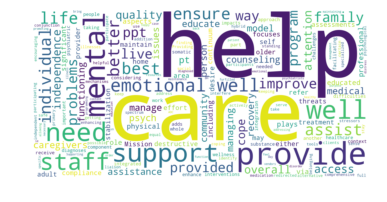

In your experience, which Behavioral Health interventions are most beneficial to PACE participants? 


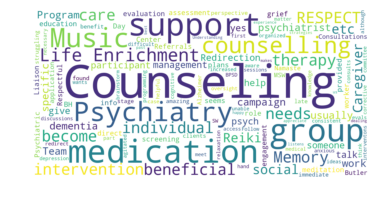

Describe the reasons you think these are beneficial.


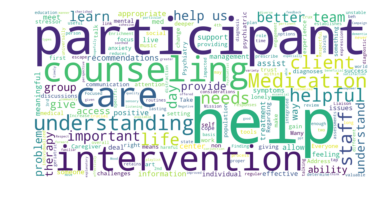

What other Behavioral Health interventions and/or services are needed that PACE does not currently provide? 


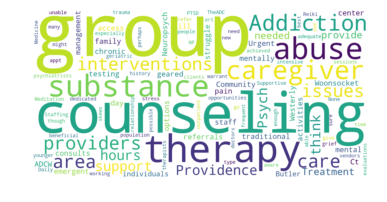

What participant problems or needs are not currently addressed by Behavioral Health actions/programming? 


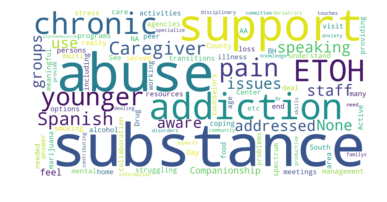

Do you find the documentation of Behavioral Health services at PACE adequate? If not, how could it be improved?


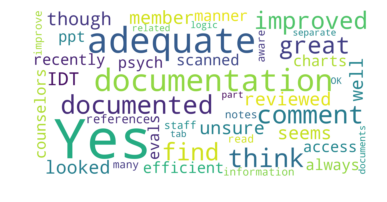

What training or education related to Behavioral Health programs and services do you need?


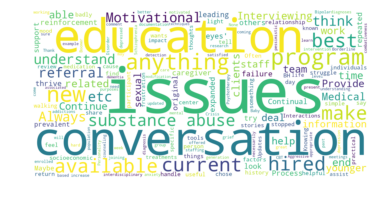

In [22]:
i = 2

stopwords = set(STOPWORDS)
stopwords.update(["ppts", "ppt", "participants",
                  "behavioral", "health", "PACE", "One",
                  "services", "training", "service", "know", "behaviors", "issue", "behavior"])
    
for q in responses.columns[2:]:
    print(q)
    text = " ".join(str(review) for review in responses[q].dropna())
    wordcloud = WordCloud(width=1600, height=800, min_font_size=10, stopwords=stopwords, background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    wordcloud.to_file(f"word_clouds/{i}_cloud.png")
    i+= 1

### A Deeper Look at Some Responses

After seeing the wordclouds the committee has requested a look at some of the responses containing certain words that stood out.

Each column is filled with all the responses to the question that is it's column name. There are two way to do this and both should be explored.

We could create a list where each element is a response and pull out the responses containing the interesting words **or** we could create another list where each element is a sentence and pull out the responses containing the interesting words.

+ Q3 - Someone
+ Q6 - Abuse
+ Q8 - Issues


In [23]:
Q3 = responses[responses.columns[3]].dropna()
Q3 = Q3.str.lower()

In [24]:
responses.columns[3]

'In your experience, which Behavioral Health interventions are most beneficial to PACE participants? '

In [25]:
for ans in Q3[Q3.str.contains('someone')]:
    print(ans)

counseling/therapy with sw. they usually wants someone to talk to.
counseling. ppt appreciate that they can talk to someone that listens to what they dealing with and their past experience. 


In [26]:
Q6 = responses[responses.columns[6]].dropna()
Q6 = Q6.str.lower()

In [27]:
responses.columns[6]

'What participant problems or needs are not currently addressed by Behavioral Health actions/programming? '

In [28]:
for ans in Q6[Q6.str.contains('abuse')]:
    print(ans)

active substance/etoh abuse, chronic mental illness in younger persons, pain management programs
substance abuse issues are being addressed but more options for resources for pace to use are needed.
substance abuse
substance abuse problems, 


In [29]:
responses.columns[8]

'What training or education related to Behavioral Health programs and services do you need?'

In [30]:
Q8 = responses[responses.columns[8]].dropna()
Q8 = Q8.str.lower()

In [31]:
for ans in Q8[Q8.str.contains('issue')]:
    print('')
    print(ans)


continual reinforcement.  i think the original training we had about how to 'look through the others eyes' and try to understand the issues leading to the behaviors could be repeated and expanded...so prevalent.  maybe the relationship between bh and socioeconomic factors in the person's history.  always more motivational interviewing.

with the increase of the younger baby boomer generation joining pace, staff will need training in understanding behavioral health issues such as bipolar, schizophrenia, borderline personality disorder etc. . i enrolled in a behavioral health 10 week  program to learn how to best help clients with these diagnoses. 

current and updated information related to behavioral health issues based on current research.

how to deal with the younger population that is coming in that have substance abuse issues in the past or present

i like any training i can get to better understand issues that come up, for example sexual behaviors , addictions, combativeness, de

In [32]:
sw_counts = pd.read_csv('sw_counts.csv')

In [33]:
responses.columns[2].title()

'From Your Perspective/Discipline, What Is The Purpose Of Behavioral Health Programs And Services At Pace, Including Participants Served In Hybrid Model?'

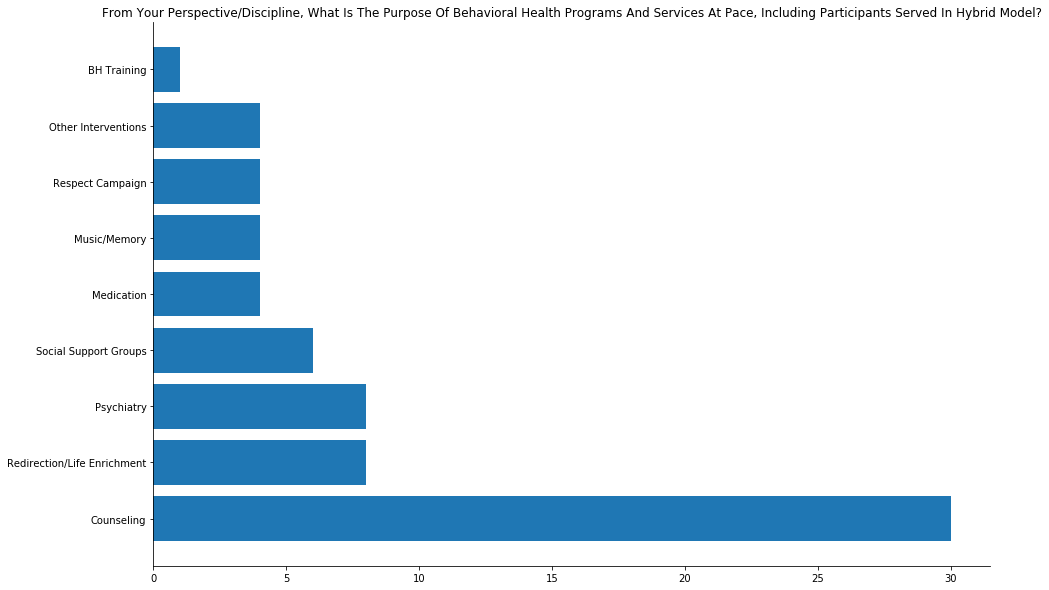

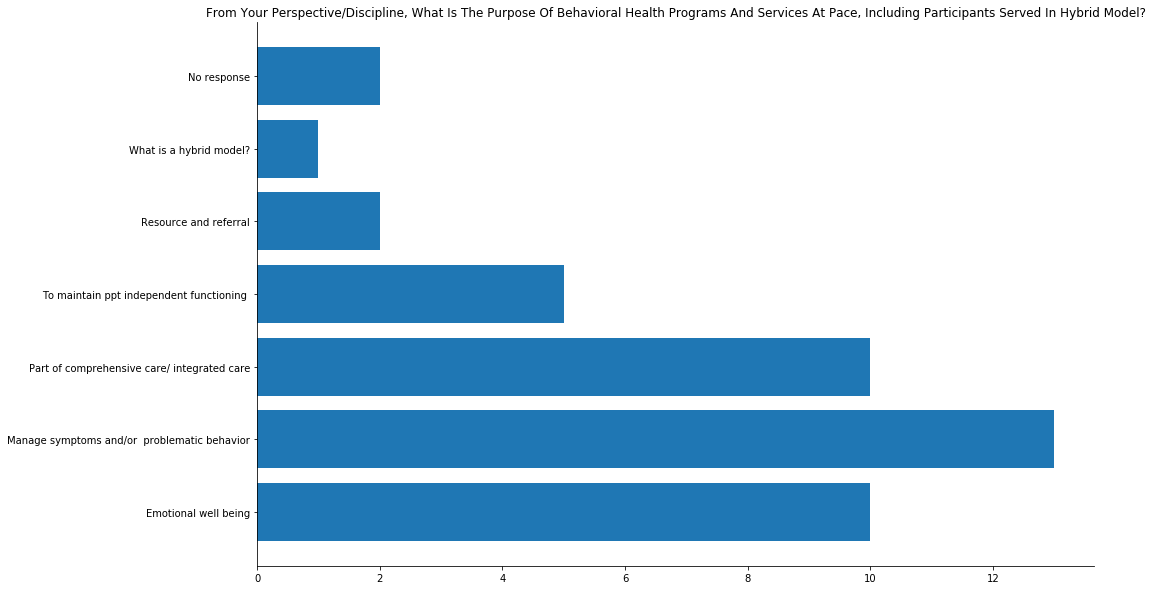

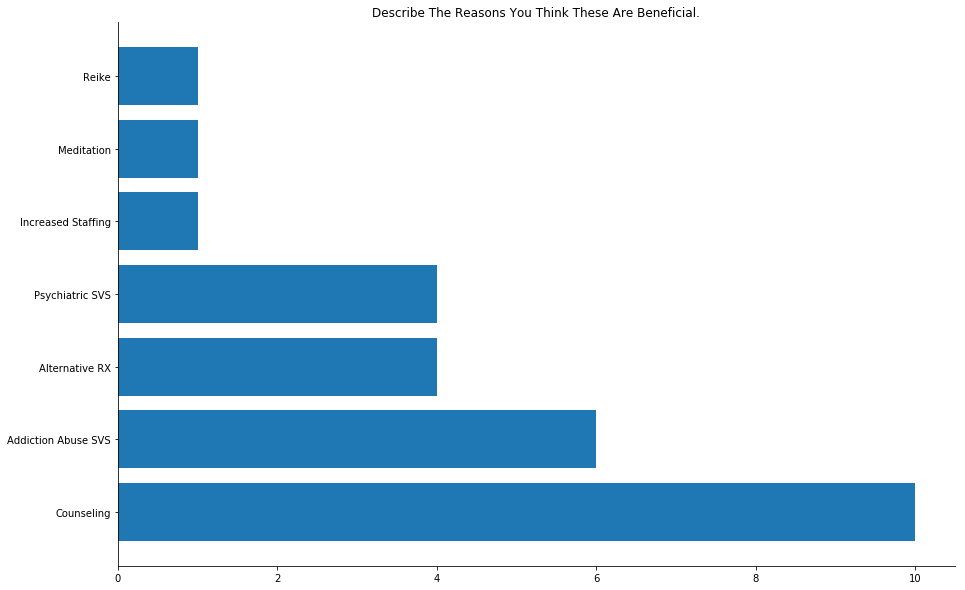

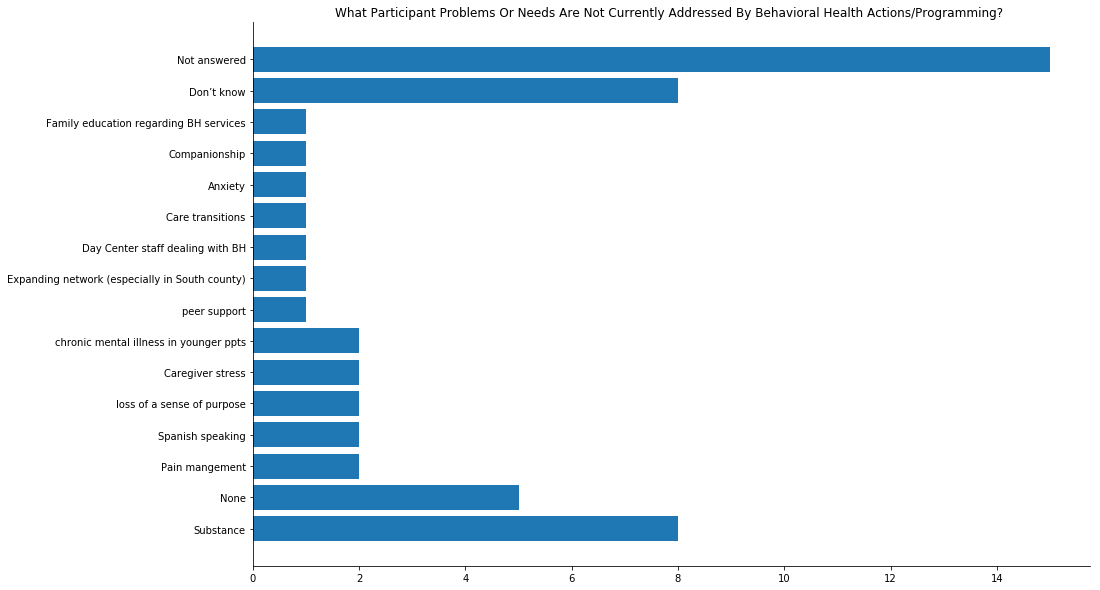

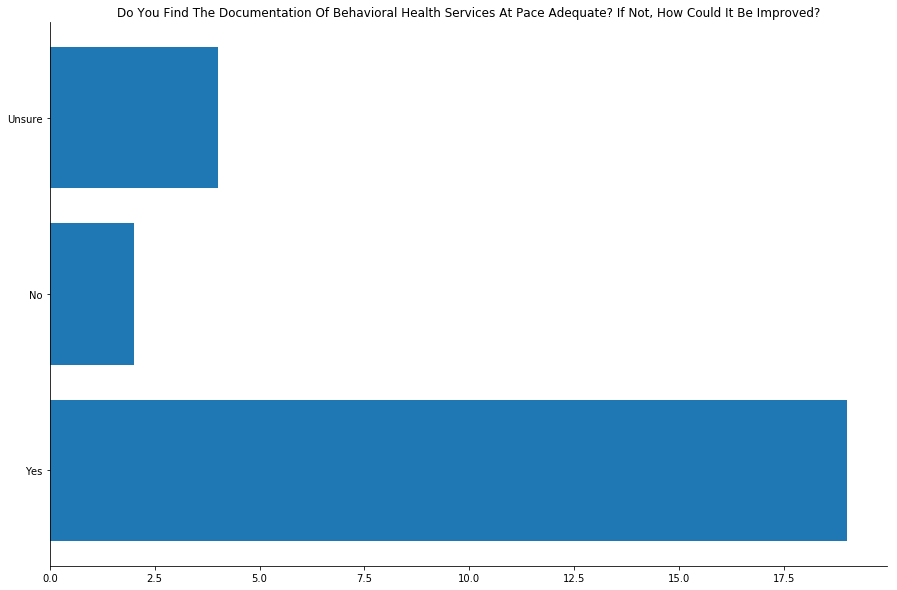

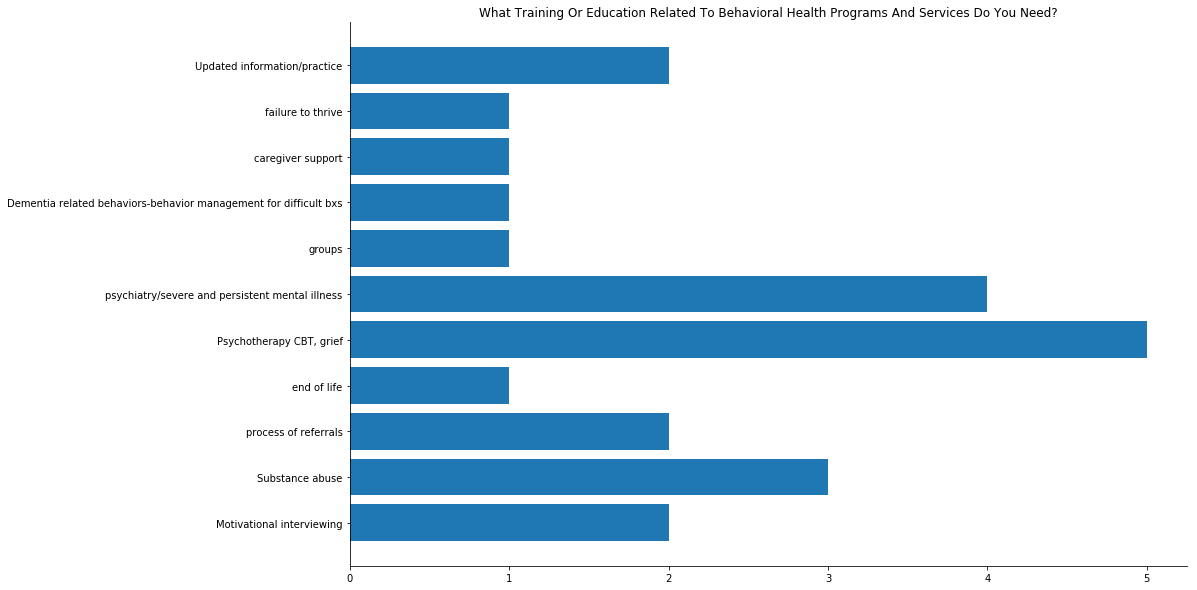

In [34]:
for i in range(0, len(sw_counts.columns), 2):
    labels = sw_counts.columns[i]
    counts = sw_counts.columns[i+1]
    fig, ax = plt.subplots(figsize=(15,10))
    ax.barh(sw_counts[labels].dropna(), sw_counts[counts].dropna())
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(responses.columns[int(sw_counts.columns[i][1])].title())
    plt.savefig(f"{labels}.png", bbox_inches='tight')

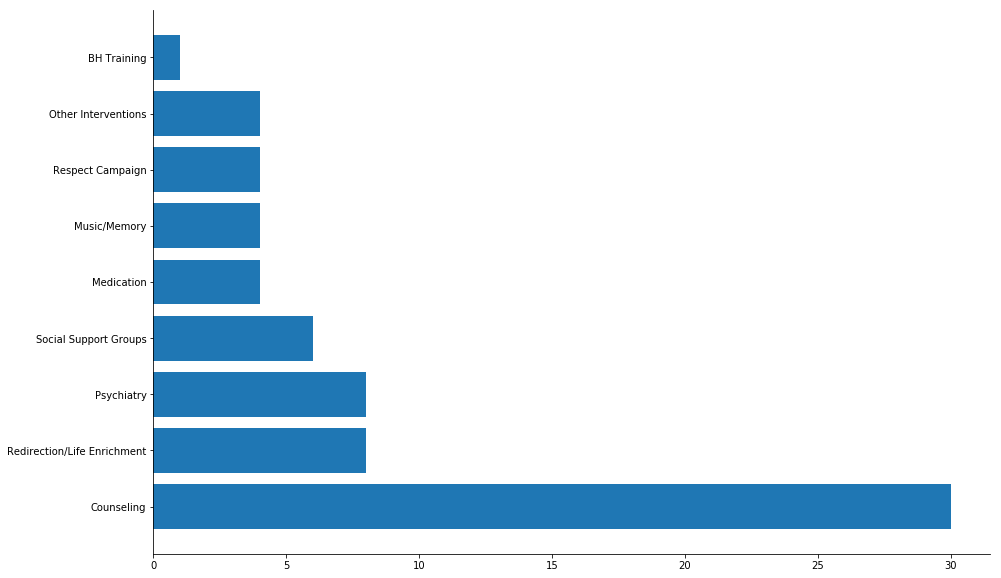

In [35]:
fig, ax = plt.subplots(figsize=(15,10))
ax.barh(sw_counts['Q2'].dropna(), sw_counts['Q2_counts'].dropna())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

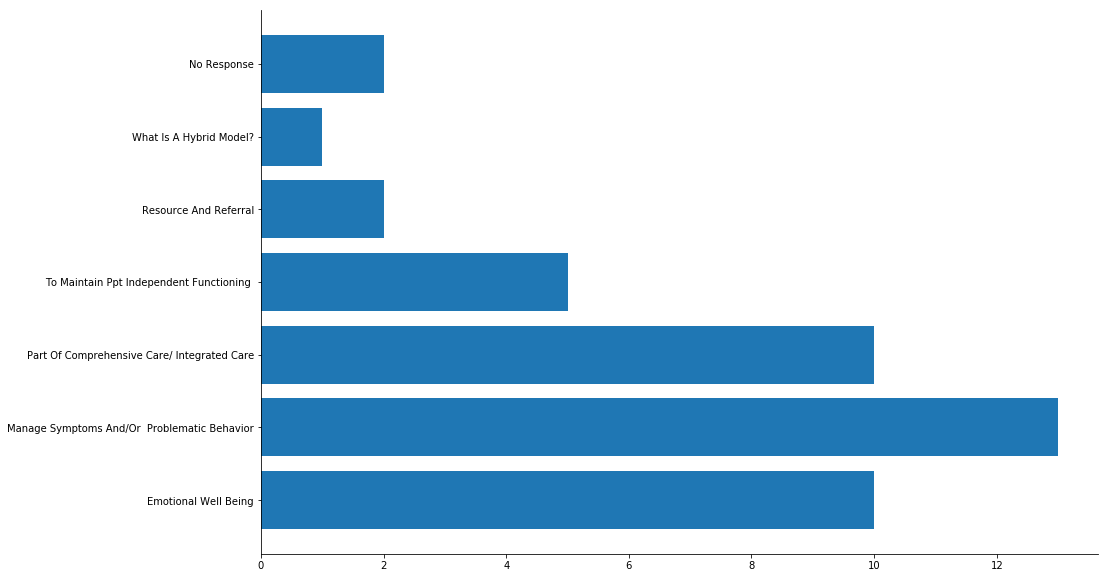

In [36]:
fig, ax = plt.subplots(figsize=(15,10))
ax.barh(sw_counts['Q2_other'].dropna().str.title(), sw_counts['Q2_other_counts'].dropna())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)